# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?


<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>

</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline
df = pd.read_csv('human_body_temperature.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [3]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [4]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [5]:
# Check if there are missing values in the data
df.isnull().sum()

temperature    0
gender         0
heart_rate     0
dtype: int64

<div class="span5 alert alert-info">
**1- Is the distribution of body temperatures normal?**
</div>

**Let's start with graphical tests**


Mean body temp is 98.24923076923078


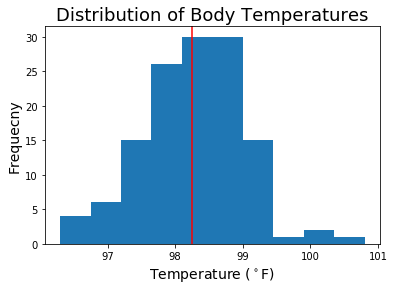

In [6]:
# Simple Histogram of the Temp
df.temperature.plot(kind='hist')

# Draw a verticle line for the mean of our sample
plt.axvline(df.temperature.mean(), c = 'red')
print('Mean body temp is {}'.format(df.temperature.mean()))

# Label axes and add title:
plt.xlabel('Temperature ($^\circ$F)', fontsize=14)
plt.ylabel('Frequecny', fontsize=14)
plt.title('Distribution of Body Temperatures', fontsize=18)

# Display the plot
plt.show()

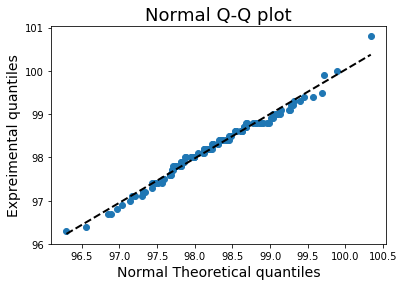

In [7]:
def q_q_check(entries):
    """ Description of q_q_check
        This function employs the Q-Q plot which provides a graphical comparison of
        two probability distributions by plotting their quantiles.
    """
    
    import numpy as np
    import numpy.random as random
    
    data = entries.sort_values().values
    mean_data = np.mean(data)
    std_data = np.std(data)
    
    # simulate randomly distributed numbers around the same statistics
    norm = random.normal(loc=mean_data, scale=std_data, size=len(data))
    norm.sort()
    
    
    # plot norm vs data
#     plt.plot(norm, 'g-', label='norm' )
#     plt.plot(data, 'b.',label='sample', linestyle='none')
#     plt.legend()
#     plt.margins(0.02)
#     plt.show()

    #plt.figure(figsize=(8,6),facecolor='1.0') 

    plt.plot(norm,data,"o")


    # Least squares polynomial fit using data points
    # Fit a polynomial of degree for given points
    z = np.polyfit(x=norm,y=data, deg= 1)
    
    p = np.poly1d(z)
    plt.plot(norm, p(norm),"k--", linewidth=2)
    plt.title("Normal Q-Q plot", size=18)
    plt.xlabel("Normal Theoretical quantiles", size=14)
    plt.ylabel("Expreimental quantiles", size=14)
    #plt.tick_params(labelsize=16)
    plt.show()
    
    
    
q_q_check(df.temperature)

**Let's look at Statistical Test**

p - score interpretation:
A result above 5% does not mean that the null hypothesis is true. It means that it is very likely true given available evidence

In [8]:
# The Shapiro-Wilk test

def s_w_test(data):
    """ Description of s_w_test
        The Shapiro-Wilk test tests the null hypothesis that the data was drawn 
        from a normal distribution
        if test_stat and p_value close to 1 then data is normal
    """
    import numpy as np
    from numpy.random import randn
    from scipy.stats import shapiro

    
    # seed the random number generator
    np.random.seed(0)
    
    statistic, p_value = shapiro(data)
    print('Shapiro Statistic: ' + str(statistic) ,'\n'
         'P_Value: ' + str(p_value), '\n')
    if p_value > 0.05:
        print('Keep H0 hypothesis, Sample Looks Gaussian')
        
    else:
        print('H0 is rejected, Sample is not Gaussian')

s_w_test(df.temperature)

Shapiro Statistic: 0.9865770936012268 
P_Value: 0.233174666762352 

Keep H0 hypothesis, Sample Looks Gaussian


In [9]:
# D'Agostino and Pearson's Test

def d_p_test(data): 
    """ Description of d_p_test
        The D'Agostino and Pearson (D'Agostino's K**2) test tests the null hypothesis that the data was drawn 
        from a normal distribution
        if test_stat and p_value close to 1 then data is normal
    """
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import normaltest
    
    
    # seed the random number generator
    seed(1)
    
    # generate univariate observations
    data = 5 * randn(100) + 50
    
    # normality test
    statistic, p_value = normaltest(data)
    print('Statistic=%.3f, p_value=%.3f' % (statistic, p_value),'\n')
    
    # interpret
    
    if p_value > 0.05:
        print('Keep H0 hypothesis, Sample Looks Gaussian')
    else:
        print('H0 is rejected, Sample is not Gaussian')
        
        
d_p_test(df.temperature)

Statistic=0.102, p_value=0.950 

Keep H0 hypothesis, Sample Looks Gaussian


Summary of Results:

    Hence, from both graphical and statistical trials we observed that the Temperature data shows Gaussian behavior so it appears to be normally distributed.

<div class="span5 alert alert-info">
**2-Is the sample size large? Are the observations independent?**
</div>

In [10]:
print('Sample size bigger than 30 is considered large: ', df.drop_duplicates().shape[0] , 'records.')

Sample size bigger than 30 is considered large:  127 records.


             temperature  heart_rate
temperature     1.000000    0.253656
heart_rate      0.253656    1.000000


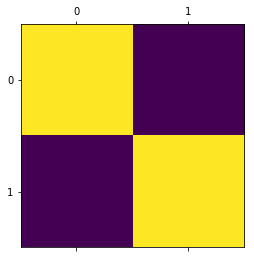

In [11]:
# Let's look at the correlation matrix of two variables 
print(df.corr())
plt.matshow(df.corr())
plt.show()


**Uncorrelatedness implies independence** Since the correlation metric close to 0', 
      'we expect no strong linearity between two variables.

<div class="span5 alert alert-info">
**3-Is the true population mean really 98.6 degrees F? **
</div>

**Start with Bootsrap Hypothesis Testing**

In [12]:
# Bootstrap Hypothesis Test
def replicate(data, function):
    ''' Return replicate of a resampled data array'''
    
    # Create the resampled array and return the statistic of interest:
    return function(np.random.choice(data, size=len(data)))


def draw_replicates(data, function, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates:
    replicates = np.empty(size)

    # Generate replicates:
    for i in range(size):
        replicates[i] = replicate(data, function)
    

    return replicates

In [13]:
# Seed the random number generator:
np.random.seed(15)


# Make an array of translated temperatures:
translated_temps = df.temperature - np.mean(df.temperature) + 98.6

# Draw bootstrap replicates of translated temperatures:
translated_replicates = draw_replicates(translated_temps, np.mean, 10000)

# Compute fraction of replicates that are less than the observed temperature mean:
p = np.sum(translated_replicates <= np.mean(df.temperature)) / len(translated_replicates)

# Print the p-value:
print('p-value =', p)

p-value = 0.0


The p_value is significantly less then 0.05, so the H0 can be rejected. Therefore, the TRUE MEAN body is not exactly 98.6 degrees of F.

** One Sample T Test**

Test for one type of sample that is human body temperature. The population Standard Dev is unknown so T test will be used. Since the sample size is bigger than 30 results would be similar to Z test results. 

**t-test conditions**

The data were collected in a random way, each observation must be independent of the others, and the sampling distribution must be normal or approximately normal

**z-test conditions**

The data were collected in a random way, each observation must be independent of the others, the sampling distribution must be normal or approximately normal, and the population standard deviation must be known

**Conditions** before applying a T Test about a mean:
- Random samples (Assuming the data collected from random samples)
- Normaly Distributed Sample (See solution to problem 1)
- Independence ( Either sampling with replacement or sample_size < .1*size_population)

Hypothesis:

H0 : The **True** population **mean** is 98.6 $^\circ$F

H1 : H0 is False

In [14]:
def t_test(data):
    '''Calculate t-statistic and p_value using temperature samples'''
    
    # Sample mean
    xbar = np.mean(data)
    
    # Population mean 
    mu0 = 98.6
    
    # Sample STD
    s = np.std(data, ddof=1)
    
    # Sample Size
    n = len(data)
    
    # T statistic for mean
    t_obs = (xbar - mu0)/ (s/np.sqrt(n))
    
    # Calculate p_value
    # two-sided pvalue = Prob(abs(t)>tvalues)
    pval = stats.t.sf(np.abs(t_obs), n-1)*2  

    return t_obs, pval

# Function Call
print(' t statistic: ' , t_test(df.temperature)[0],'\n',
      'p_value: ', t_test(df.temperature)[1] )

 t statistic:  -5.454823292364079 
 p_value:  2.4106320415609943e-07


In [15]:
# Confirm the statistic and p_value with built-in one sample t-test method
c_t, c_p = stats.ttest_1samp(df.temperature, popmean=98.6)
print('t_statistic:  {t} \np_value: {p}'.format(t=c_t, p=c_p))

t_statistic:  -5.4548232923645195 
p_value: 2.4106320415561276e-07


**T  statistic** tells us how much the sample mean deviates from the null hypothesis. If the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom, we reject the null hypothesis. YES IT DOES LIE OUTSIDE as seen lines below:

The p_value is the probability to observe a value t more than the observed one t_obs under the H0.

    H0: P(t>t_obs|H0)

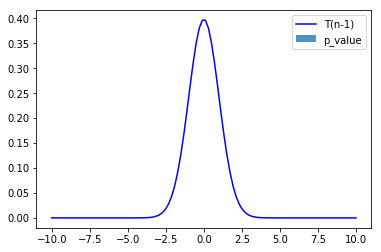

We should have got a blue region near the right tail, but we do not see it because probablity is too low. In other words, it is almost not possible to get more exreme t_value than the observed one t_obs which lies out of the 


In [16]:
# Visualizing p_value
import scipy.stats as stats

# Sample size
n = len(df.temperature)

# T statistic and possible t values
t_obs = abs(t_test(df.temperature)[0])
tvalues = np.linspace(-10,10,100)

# Plot PDF for possible t-values
plt.plot(tvalues, stats.t.pdf(tvalues, n-1), 'b-', label = 'T(n-1)')


# Determine the area where t values are bigger than observed t-statistic
upper_tval_tvalues = tvalues[tvalues > t_obs]
plt.fill_between(upper_tval_tvalues,0, stats.t.pdf(upper_tval_tvalues, n-1), alpha=0.8,label='p_value')
plt.legend()
plt.show()

print('We should have got a blue region near the right tail, but we do not see it because probablity is too low.', 
     'In other words, it is almost not possible to get more exreme t_value than the observed one t_obs',
     'which lies out of the ')

In [17]:
# Find the Confidence Interval for the mean body temperature for 95 % Confidence Level 
# Critical Value for 95% (two tail) confidence level using percent point function from student's t in stats module
# Sample size
n = len(df.temperature)
cv = stats.t.ppf(0.975,n-1)

# Margin of Error at the 95% confidence level
me = cv*(np.std(df.temperature)/ np.sqrt(n))

# Find the confidence interval for the t-test at 95% confidence level
c_intvl = (np.mean(df.temperature)- me, np.mean(df.temperature) + me)
print('The Confidence Interval for 95% C Level for all possible means :' ,c_intvl)

The Confidence Interval for 95% C Level for all possible means : (98.12249318821641, 98.37596835024515)


So the *TRUE MEAN* (population mean) would fall into the interval of 


$$(Sample\_Mean - CV*SE , Sample\_Mean + CV*SE)$$  where $$SE = \frac{STD(Sample)}{\sqrt{\left(Sample\_Size\right)}}$$ and 


$$ CV = Critical Value$$




Thereofre with the results,  we cannot say that the TRUE MEAN is 98.6 degrees F. Furthermore, we can reject the H0 hypothesis that the exact population mean temperature is 98.6 F as the p_value obtained above was far less    then 0.05 for the 95 % confidence level.


Mean of the sampling distribution of the mean:  98.25000800000001


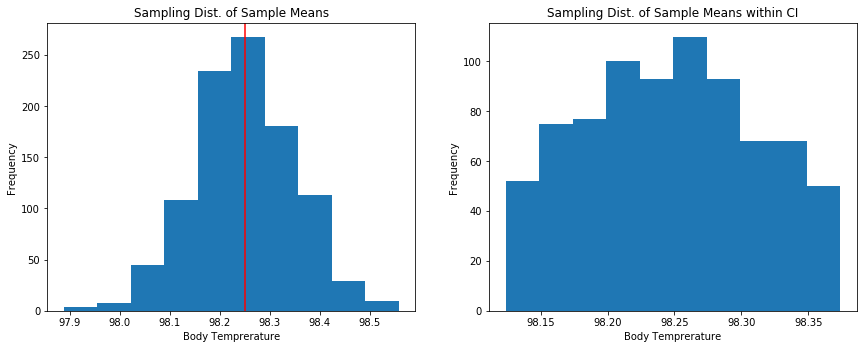

In [18]:
# Now Let's look at sampling distribution of the sample means  
sampling = np.empty(1000)
for i in range(1000):
    sampling[i] = df.temperature.sample(50, replace=True).mean()
means_in_cint = [ x for x in sampling if (x < c_intvl[1] and x > c_intvl[0]) ]
print('Mean of the sampling distribution of the mean: ',np.mean(sampling))

# Plot Sampling Distribution and The Distribution of the means within Confidence Interval
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(sampling)
ax1.set_title('Sampling Dist. of Sample Means')
ax1.set_xlabel('Body Temprerature')
ax1.set_ylabel('Frequency')
ax1.axvline(np.mean(sampling), c='r')

ax2.hist(means_in_cint)
ax2.set_title('Sampling Dist. of Sample Means within CI')
ax2.set_xlabel('Body Temprerature')
ax2.set_ylabel('Frequency')
plt.subplots_adjust(bottom=0, right=2.0, top=1.0)
plt.show()

____

** Z-Test **

In [19]:
def z_test(data):
    '''Calculate z-statistic and p_value using temperature samples'''
    
    # Sample mean
    xbar = np.mean(data)
    
    # Population mean 
    mu0 = 98.6
    
    # Sample STD
    s = np.std(data, ddof=1)
    
    # Sample Size
    n = len(data)
    
    # T statistic for mean
    z_obs = (xbar - mu0)/ (s/np.sqrt(n))
    
    # Calculate p_value
    # two-sided pvalue = Prob(abs(t)>tvalues)
    pval = stats.norm.sf(abs(z_obs))*2

    return z_obs, pval

# Function Call
print(' z statistic: ' , z_test(df.temperature)[0],'\n',
      'p_value: ',z_test(df.temperature)[1] )


 z statistic:  -5.454823292364079 
 p_value:  4.90215701411338e-08


In [20]:
# Verify z- test with z-test function from weightstats
import statsmodels.stats.weightstats as wstats

# Get the z statistic and p_value
z, p_val = wstats.ztest(df.temperature, value=98.6, ddof=1.0)
print('z-statistic = {z} \np-value = {p}'.format(z=z,p=p_val))

z-statistic = -5.4548232923645195 
p-value = 4.9021570141012155e-08


**Z-Test** supports that the Null hypothesis can be rejected.

<div class="span5 alert alert-info">
<ul>
**4-Draw a small sample of size 10 from the data and repeat both frequentist tests.**

<li>Which one is the correct one to use?

<li>What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?

</ul>
</div>


In [21]:
# Now Let's look at sampling distribution of the sample means  
tens = df.temperature.sample(10,replace=True)

(array([1., 0., 0., 0., 1., 0., 3., 2., 1., 2.]),
 array([96.3 , 96.55, 96.8 , 97.05, 97.3 , 97.55, 97.8 , 98.05, 98.3 ,
        98.55, 98.8 ]),
 <a list of 10 Patch objects>)

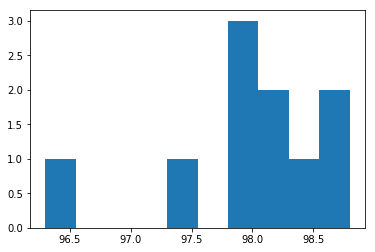

In [22]:
plt.hist(tens)

In [23]:
# T-Test for 10 samples
t, p_val_t = stats.ttest_1samp(a=tens, popmean=98.6)
print('t-statistic = {t} \np-value = {p}'.format(t=t,p=p_val_t))

t-statistic = -2.7333952307624303 
p-value = 0.02309584980628976


In [24]:
# Z-Test for 10 samples 
import statsmodels.stats.weightstats as wstats

# Get the z statistic and p_value
z, p_val_z = wstats.ztest(tens, value=98.6, ddof=1.0)
print('z-statistic = {z} \np-value = {p}'.format(z=z,p=p_val))

z-statistic = -2.7333952307624303 
p-value = 4.9021570141012155e-08


First note that the sample is not met with Normality condition to apply either Z or T tests. So assume that it is normally distributed.

The correct test to use in the case of random sample of size=10 is a T -test. However, the statistics from both tests are the same implying the measure of spread for sample mean from given population mean of 98.6



With confidence level of 95 % for the same samples, we have enough evidence to reject Null Hyp. with the result from T-Test but not with the Z Test. 

Probability of getting a t-value at least as extreme as observed t_obs
$$P(t >t\_obs | H0) \approx 0.3 \%  $$

Probability of getting a z-value at least as extreme as observed z_obs
$$P(z >z\_obs | H0) \approx 11 \%  $$

p only indicates the likelihood of obtaining a certain value for the test statistic if the null hypothesis is true—nothing else. A value of p < 0:05 for the null hypothesis has to be interpreted as follows: If the null hypothesis is true, the chance to find a test statistic as extreme as or more extreme than the one observed is less than 5 %. This is not the same as saying that the null hypothesis is false, and even less so, that an alternative hypothesis is true!

<div class="span5 alert alert-info">
**5- At what temperature should we consider someone's temperature to be "abnormal"?**
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
        
</ul>       
</div>

**Bootstrap Approach**

In [25]:
def replicate(data, function):
    ''' Return replicate of a resampled data array'''
    
    # Create the resampled array and return the statistic of interest:
    return function(np.random.choice(data, size=len(data)))


def draw_replicates(data, function, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates:
    replicates = np.empty(size)

    # Generate replicates:
    for i in range(size):
        replicates[i] = replicate(data, function)
    

    return replicates

In [26]:
# Compute the confidence interval
replicates = draw_replicates(np.array(df.temperature), np.mean, 10000)

# Standard Error
x1= replicates
SE_rep = stats.sem(x1) 

# t-critical at 95% confidence Level with 129 degrees of freedom
t_c_rep = stats.t.ppf(0.975, df=len(x1)-1) 

# Margin of Error
moe_rep = t_c_rep * SE_rep

# Confidence Interval
CI_rep = x1.mean() - moe_rep , x1.mean() + moe_rep
CI_rep

(98.24845126388473, 98.25099304380757)

We could say that the values out of the above range is abnormal temperature values.

**Frequentist Approach**

*Tail Prob Calculator for T - Test*

In [27]:
# One tail 95% Confidence Level
alpha = .05
p = 1-alpha

# get the value <= probability
critical_v = stats.t.ppf(p, df=30)
#print(critical_v)

# confirm the area with cdf
pp = stats.t.cdf(critical_v, df=30)
print('The critical value: {cv}\nThe Area under the curve up to cut off point: {area}'.format(cv=critical_v,
                                                                                             area=pp))

The critical value: 1.6972608943617378
The Area under the curve up to cut off point: 0.9500000007419639


In [28]:
# Two Tail 95% Confidence Level
alpha = .05/2
p = 1-alpha

# get the value <= probability
critical_v = stats.t.ppf(p, df=30)
#print(critical_v)

# confirm the area with cdf
pp = stats.t.cdf(critical_v, df=30)
print('The critical value: {cv}\nThe Area under the curve up to cut off point: {area}'.format(cv=critical_v,
                                                                                             area=pp))

The critical value: 2.0422724563012373
The Area under the curve up to cut off point: 0.9749999999999999


*Tail Prob Calculator for Z (Normal Dist.) - Test*

In [29]:
# here

In [30]:
import scipy.stats as stats

#Standard Error
x = df.temperature

# Sample Size
# ddof = 1 is default -- Delta Degrees of Freedom
n = len(x)
SE = stats.sem(x, ddof = 1) 
#SE = (x.std()/np.sqrt(len(x)))

# t-critical at 95% confidence Level with 129 degrees of freedom
t_c = stats.t.ppf(0.975, df=n-1) 

# Margin of Error
moe = t_c * SE

# Confidence Interval
CI = x.mean() - moe , x.mean() + moe
CI

(98.12200290560804, 98.37645863285351)

In [31]:
# calculate 95% confidence interval (two tail)
conf_int = stats.t.interval(alpha=0.975, df=n-1, loc=np.mean(df['temperature']), scale=np.std(df['temperature']))

print('95% confidence interval:',conf_int)

95% confidence interval: (96.59287726787744, 99.90558427058413)


The Confidence Interval remains the similar at the 95% Confidence Level, only the first one is narrower. So we consider temperatures lie out the ranges above as Abnormal Body Temperatures. However, the mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years. 

Is something wrong!?
Looks like 98.6$^{\circ}$F is an abnormal body temperature for humans! 

Only we get wider range that contains the asserted  98.6$^{\circ}$F interval if used built-in confidence interval function from scipy stats

<div class="span5 alert alert-info">
** 6- Is there a significant difference between males and females in normal temperature?**
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</div>

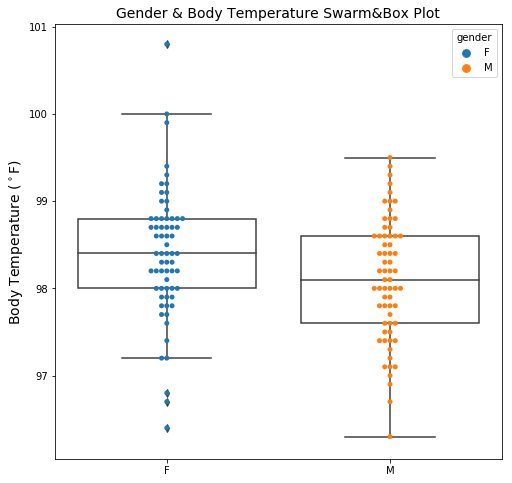

In [32]:
import seaborn as sns
plt.figure(figsize = (8,8))
_ = sns.swarmplot(x= 'gender', y = 'temperature',hue='gender' ,data = df)
_ = sns.boxplot(x="gender", y="temperature", data=df, boxprops={'facecolor':'None'})
_ = plt.xlabel('')
_ = plt.ylabel('Body Temperature ($^\circ$F)', fontsize=14)
_ = plt.title ('Gender & Body Temperature Swarm&Box Plot', fontsize=14)
plt.show()

Two Sample T - Test will be used to analyze two independent samples from two separate groups. Here is the Null hypothesis is 

H0 : Two samples do have the same mean or The difference between two population means is 0.

The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages. [source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [33]:
# Statistics by Gender
male_stats = df[df.gender=='M'].describe()
female_stats = df[df.gender=='F'].describe()
pd.merge(male_stats, female_stats, how='outer', left_on=male_stats.index, right_on=female_stats.index )

,key_0,temperature_x,heart_rate_x,temperature_y,heart_rate_y
0,count,65.000000,65.000000,65.000000,65.000000
1,mean,98.104615,73.369231,98.393846,74.153846
2,std,0.698756,5.875184,0.743488,8.105227
3,min,96.300000,58.000000,96.400000,57.000000
4,25%,97.600000,70.000000,98.000000,68.000000
5,50%,98.100000,73.000000,98.400000,76.000000
6,75%,98.600000,78.000000,98.800000,80.000000
7,max,99.500000,86.000000,100.800000,89.000000


In [34]:
rv_m = df[df.gender=='M'].temperature
rv_f = df[df.gender=='F'].temperature
t_statistic_, p_value_ = stats.ttest_ind(rv_m, rv_f, equal_var=True)
print('t-statistic = {t} \np-value = {p}'.format(t=t_statistic_,p=p_value_))

t-statistic = -2.2854345381656103 
p-value = 0.02393188312239561


Results suggest that there is a difference between the two means, as deviation is  not 0. The summary statisctics table above also shows that there is a small differencen in the mean values of two groups.

Morever, p value of 2.4% 
is slightly less than 5% so we can reject the null hypothesis.

<div class="span5 alert alert-info">
**Conclusion**
</div>

- The distribution characteristics of the data is very important for the inferential statistics. Many statistical models assume data normally distributed and from there provide us the appropriate statitical tests. 
- Statistical tests are used to check the difference between our expectation and the facts about our data. For that data must be randomly selected, and that ideally individual events should be independent of each other to get accurate results from statistical tests.
- We see that t-test is good for sample size less than 30 and it approaches to normal distribution as the sample size increases. Having smaller samples affects the accuracy of the analysis, so does have an impact on the inference.

<div class="span5 alert alert-info">
**What is the True Mean Value Of Human Body Temp.**
</div>

- Statistical tests for our sample, which is normally distributed with the mean of $98.2^{\circ}F$, suggest that the actual mean value is different than the conventional value of $98.6^{\circ}F$. Our results demonstrated that with 95% Confidence Level the all possible means from sampling distribution of the sample means should fall into the confidence interval of $$[98.12^{\circ}F, 98.37^{\circ}F]$$


- We observed that the mean value of body temperature differs slightly. We do not know if the gender has an effect on the result nor the cause of that differentiation. 
- It might be heart rates, the region people selected from,  the diet habbits or might be something else that we do not have the data about.  

/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


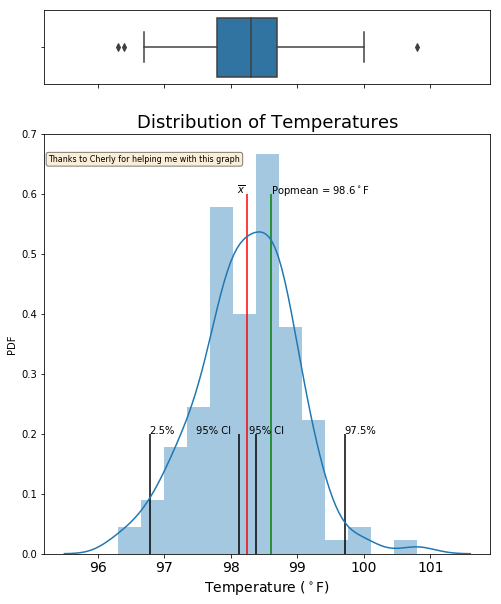

In [36]:
import seaborn as sns


# CI : Confidence Interval from Question 5 for 95% Confidence Level Accuracy

# Create a figure with two plots:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
fig.set_size_inches(8,10)
# Add boxplot for temperature:
sns.boxplot(df.temperature, ax=boxplot)

# Add histogram for temperature:
sns.distplot(df.temperature, ax=histogram)

# Increase tick mark font size, label axes and add title:
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel('Temperature ($^\circ$F)', fontsize=14)
plt.ylabel('PDF')
plt.title('Distribution of Temperatures', fontsize=18)

# Add text and lines marking the 99.9% confidence interval:
plt.text(x=CI[0]-0.65, y=0.2, s='95% CI')
plt.vlines(ymin=0, ymax=0.2, x=CI[0])
plt.text(x=CI[1]-0.1, y=0.2, s='95% CI')
plt.vlines(ymin=0, ymax=0.2, x=CI[1])

# Add a lines for different means:
sample_mean = df.temperature.mean()
plt.text(x=sample_mean-0.15, y=0.6, s='$\overline{x}$')
plt.vlines(ymin=0, ymax=0.6, x=sample_mean, color='red')
plt.text(x=98.6, y=0.6, s='Popmean = 98.6$^\circ$F')
plt.vlines(ymin=0, ymax=0.6, x=98.6, color='green')

# Add text and lines marking the 95% prediction interval:
sample_std = df.temperature.std()
plt.text(x=(sample_mean-2*sample_std), y=0.2, s='2.5%')
plt.vlines(ymin=0, ymax=0.2, x=(sample_mean-2*sample_std))
plt.text(x=(sample_mean+2*sample_std), y=0.2, s='97.5%')
plt.vlines(ymin=0, ymax=0.2, x=(sample_mean+2*sample_std))

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Save and display the plots:
plt.savefig('description.png')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


# place a text box in upper left in axes coords
textstr = 'Thanks to Cherly for helping me with this graph'
plt.text(0.01, 0.95, textstr, transform=histogram.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

plt.show()

<div class="span5 alert alert-info">
</div>